In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(rasqualTools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(parallel))

In [2]:
coln = c('Feature','rsID','Chromosome','position','Ref' ,'Alt' ,'Af','HWEChi_square' ,'IA','Log10_qval','Chi_square',
        'Effect_size','Sequencing_mapping_error_rate','Ref_allele_bias' ,'Overdispersion','SNPid_within_region',
        'No_fSNPs','No_tested_SNPs','No_iterations_for_H0','No_iterations_for_H1',"ties",'Log_likelihood_H0',
        'Convergence_status','r2_fSNPs','r2_rSNP')

In [122]:
rasqual_caQTL = function(x, snp_counts, counts, offsets, covariates,  vcf=vcf_file, outdir, outlogdir,
                         nsamples=10, lead=TRUE, permut=FALSE) 
{
region  = paste0(snp_counts$chromosome_name[x], ":",snp_counts$range_start[x] ,"-",snp_counts$range_end[x])
outfile = paste0(outdir, "/",  snp_counts$gene_id[x])   
outlog    = paste0(outlogdir,"/",  snp_counts$gene_id[x], ".log")
    
system(paste("tabix",  vcf, region, "| $RASQUALDIR/bin/rasqual", 
'-y', counts,
'-k', offsets,
'-x', covariates,
"-n", nsamples,             
'-j', indexes[x] ,
'-l', snp_counts$cis_snp_count[x] ,
'-m', snp_counts$feature_snp_count[x] , 
'-s', snp_counts$exon_starts[x],
'-e', snp_counts$exon_ends[x] , 
'-f', snp_counts$gene_id[x],            
 c("","-t" )  [(lead==TRUE) +1]   ,
 c("","-r" )  [(permut==TRUE) +1]   ,
#'--min-coverage-depth 6',
             '--population-only',
'>', outfile, "2>", outlog))
    
}

In [133]:
###### set parmetes here ######
maindir     = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/subsample_test/'
celltypes   = list.files(maindir)[!grepl(".txt", list.files(maindir))]
P           =  TRUE ## permutation?  
folder_name = 'run3_lead_poponly_perm2'
L           =  TRUE ## report only lead?
nsamples    = 10
####################################

setwd(maindir)

In [134]:
celltypes 

[1] "sub10"   "sub100"  "sub1000" "sub2000" "sub25"   "sub250"  "sub50"  
[8] "sub500"

In [135]:
for (c in celltypes){

cat (c, "\n")
counts      = paste0( c, "/counts.",c, ".bin" )
offsets     = paste0( c, "/size_factors.",c, ".bin" )
covariates  = paste0( c, "/covariates.",c, ".bin" )


inp = read.table(paste0( c, "/counts.",c, ".txt" ), row.names=1)
cm  = read.table(paste0( c,"/",c, ".count_matrix" ), header=T, stringsAsFactors = F)

peak_data = cm[,c(1,2,5,3,4)]
peak_data$Strand = as.integer(1)
colnames(peak_data) =  c('gene_id','chr','strand','exon_starts','exon_ends')
peak_data$exon_starts = as.character(peak_data$exon_starts)
peak_data$exon_ends = as.character(peak_data$exon_ends)

vcf_dir = paste0(c, '/vcfs_peaksonly/' )

    
system(paste0("bcftools query -f '%CHROM\\t%POS\\t%ID\\n' ", 
              vcf_dir,  "full.ase.filtered.vcf.gz > ",  vcf_dir, 'full.ase.filtered.snps'))
   
snps2           = read.table(paste0(vcf_dir, "full.ase.filtered.snps"))
colnames(snps2) = c('chr','pos','snp_id')
    
snp_counts2 = countSnpsOverlapingExons(peak_data, snps2, cis_window = 10000)
snp_counts2 = subset(snp_counts2, feature_snp_count>0 |  cis_snp_count> 0)
snp_counts_sub = subset(snp_counts2, gene_id %in% rownames(inp))

indexes =  match ( snp_counts_sub$gene_id,rownames(inp))

cat(sum(rownames(inp[indexes,])!= snp_counts_sub$gene_id), "\n")

sp = split(snp_counts_sub, snp_counts_sub$chromosome_name)

for ( n in 1:22){

chrom  = paste0("chr", n)
outdir = paste( c, folder_name , chrom, sep ="/")
system(paste('mkdir -p', outdir))
outlogdir = paste0(outdir, "/logs")
system(paste("mkdir",outlogdir ))
    
snp_counts_use = sp[[chrom]]
indexes        =  match ( snp_counts_use$gene_id,rownames(inp))

vcf_file = paste0(vcf_dir,  'full.ase.filtered.vcf.gz' )
    

mclapply(1:nrow(snp_counts_use), function(x) rasqual_caQTL(x, snp_counts_use, counts, offsets, covariates, 
                                                           nsamples=nsamples, 
                                                           vcf=vcf_file, outdir=outdir, outlogdir=outlogdir ,
                                                           lead=L, permut=P) , mc.cores = 32 )
         }
    
    }

sub10 
0 
sub100 
0 
sub1000 
0 
sub2000 
0 
sub25 
0 
sub250 
0 
sub50 
0 
sub500 
0 


In [136]:
# for (c in celltypes){
#     logdir = paste0( c, "/",folder_name , "_logs")
#     dir.create(logdir)
# for ( n in 1:22){
#         chrom  = paste0("chr", n)
#         outdir = paste( c, folder_name , chrom, "logs",sep ="/")
#         files = na.omit(list.files(outdir)[sapply(paste(outdir, list.files(outdir),sep="/"), file.size) >0])
#  if(length(files)>0) {      
#     error_files= paste(outdir, files, sep="/")
#      for (err in error_files){
#      system(paste("mv", err, logdir))
#     }
#      }
#     system(paste("rm -r",outdir ))
    
#             }
    
#     }

In [ ]:
compile_results = function(n,folder_name,outdir ){
  	    chrom  = paste0("chr", n)
        outdir = paste( c, folder_name , chrom, sep ="/")
        system(paste0("cat ", outdir,  "/* > ", c , "/", folder_name,".results_chr", n))
    }


for (c in celltypes){
    cat (c, "\n")
    tabname = paste0(c, "/Results_", folder_name, ".tsv")
    
        
 mclapply (1:22, function(x) compile_results(n=x,folder_name=folder_name,outdir=outdir))
         
        system(paste0("cat ", c , "/", folder_name,".results_chr* > ", tabname))
        system(paste0("rm ", c , "/", folder_name,".results_chr*"))
         results           = read.table(tabname, fill=T)
         colnames(results) = coln
         results           = subset(results,results$rsID !="SKIPPED")
         results$P_VAl     = pchisq(results[,11], 1, lower=F)
         write.table(results, tabname, sep="\t", quote=F)

}


In [48]:
# for (c in celltypes){
#     for ( n in 1:22){
#         chrom  = paste0("chr", n)
#         outdir = paste( c, folder_name , chrom, sep ="/")         
#         system(paste0("rm -r ", outdir))
        
#             }
#     system(paste0("rm -r ", c, "/", folder_name))
#  }

### Calculte empirical q-value from the permutations.
see: https://github.com/natsuhiko/rasqual/issues/21

In [48]:
# q1 : real lead Q-value vector for all peaks from RASQUAL
# q0 : permutated Q-value vector
# alpha : FDR threshold
# This function returns the P-value threshold corresponding to FDR=alpha.
getFDR <-
function(q1, q0, alpha=0.1, z=NULL, subset=NULL){
	if(is.null(z)){
		a=0
		for(itr in 1:10){
			a=getFDR(q1,q0,alpha,rev(a+0:100/100^itr),subset)
		}
		a
	}else{
		if(!is.null(subset)){
			q1=q1[subset]
			q0=q0[subset]
		}
		q1=q1[!is.na(q1)]
		q0=q0[!is.na(q0)]
		x=NULL;
		for(i in z){
			x=c(x,sum(q0<i)/length(q0)/(sum(q1<i)/length(q1)))
		};
		max(c(0,z[x<alpha]),na.rm=T)
	}
}


In [49]:
celltypes

[1] "sub10"   "sub100"  "sub1000" "sub2000" "sub25"   "sub250"  "sub50"  
[8] "sub500"

In [138]:
df = data.frame()
for (c in celltypes) {
results       = read.table(paste0(c, "/Results_run3_lead_poponly.tsv"), header=T, stringsAsFactors = F)
random        = read.table(paste0(c, "/Results_run3_lead_poponly_perm1.tsv"), header=T, stringsAsFactors = F)
random2       = read.table(paste0(c, "/Results_run3_lead_poponly_perm2.tsv"), header=T, stringsAsFactors = F)
results       = results[order(results$P_VAl),]
results_lead  = results[!duplicated(results$Feature),]
    
thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.1) 
thresh05       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.05) 
thresh01       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.01) 

results_lead$flag_fdr10 = 10^(results_lead$Log10_qval) < thresh10
results_lead$flag_fdr05 = 10^(results_lead$Log10_qval) < thresh05
results_lead$flag_fdr01 = 10^(results_lead$Log10_qval) < thresh01
results_lead$exclude = results_lead$Sequencing_mapping_error_rate>0.1 | results_lead$Ref_allele_bias<0.2 | results_lead$Ref_allele_bias>0.8
     
    
df = rbind(df, c(thresh10, sum(results_lead$flag_fdr10 & results_lead$exclude ==FALSE, na.rm=T) , 
                   thresh05, sum(results_lead$flag_fdr05 & results_lead$exclude ==FALSE, na.rm=T),
                   thresh01, sum(results_lead$flag_fdr01 & results_lead$exclude ==FALSE, na.rm=T), nrow(results_lead)))

write.table(results_lead, paste0(c, "/Results_run3_lead.tsv"),sep="\t", quote=F, row.names=F)    

}
rownames(df) = celltypes
colnames(df) = c('pval_fdr10%', 'caQTL_fdr10%', 'pval_fdr05%', 'caQTL_fdr05%','pval_fdr01%', 'caQTL_fdr01%', "tested_features")


In [139]:
df

,pval_fdr10%,caQTL_fdr10%,pval_fdr05%,caQTL_fdr05%,pval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sub10,0.00000000,0,0.000000000,0,0.000000000,0,1863
sub100,0.04495276,13,0.041390177,12,0.028133694,7,27389
sub1000,0.03854436,179,0.002948469,3,0.002948469,3,91357
sub2000,0.03955140,323,0.009556896,60,0.003484777,12,107388
sub25,0.00000000,0,0.000000000,0,0.000000000,0,8975
sub250,0.05925347,67,0.000000000,0,0.000000000,0,49070
sub50,0.00000000,0,0.000000000,0,0.000000000,0,15921
sub500,0.03620624,63,0.027093418,38,0.012445795,13,69523


In [61]:
#plot(as.numeric(substring(celltypes,4)), df[,2])

In [ ]:
long

In [62]:
qqplotf = function(pvalues, title){
coaccP = sort(-log(pvalues, 10))
set.seed(1)
uniP = runif(length(coaccP))
uniP = sort(-log10(uniP))

plot(uniP, coaccP, pch=20, cex=1, xlab="Theoretical -Log10(P)", ylab="-Log10(P) caQTLs", main =title)
abline(0,1)
chisq <- qchisq(1-pvalues,1)
lgc = median(chisq)/qchisq(0.5,1)
    
    #median(qchisq(p, df=1, lower.tail=FALSE)) / qchisq(0.5, 1)
    mtext(paste("Lgc=", round(lgc,2), "MedianPval=", round(median(pvalues),3)))  
}

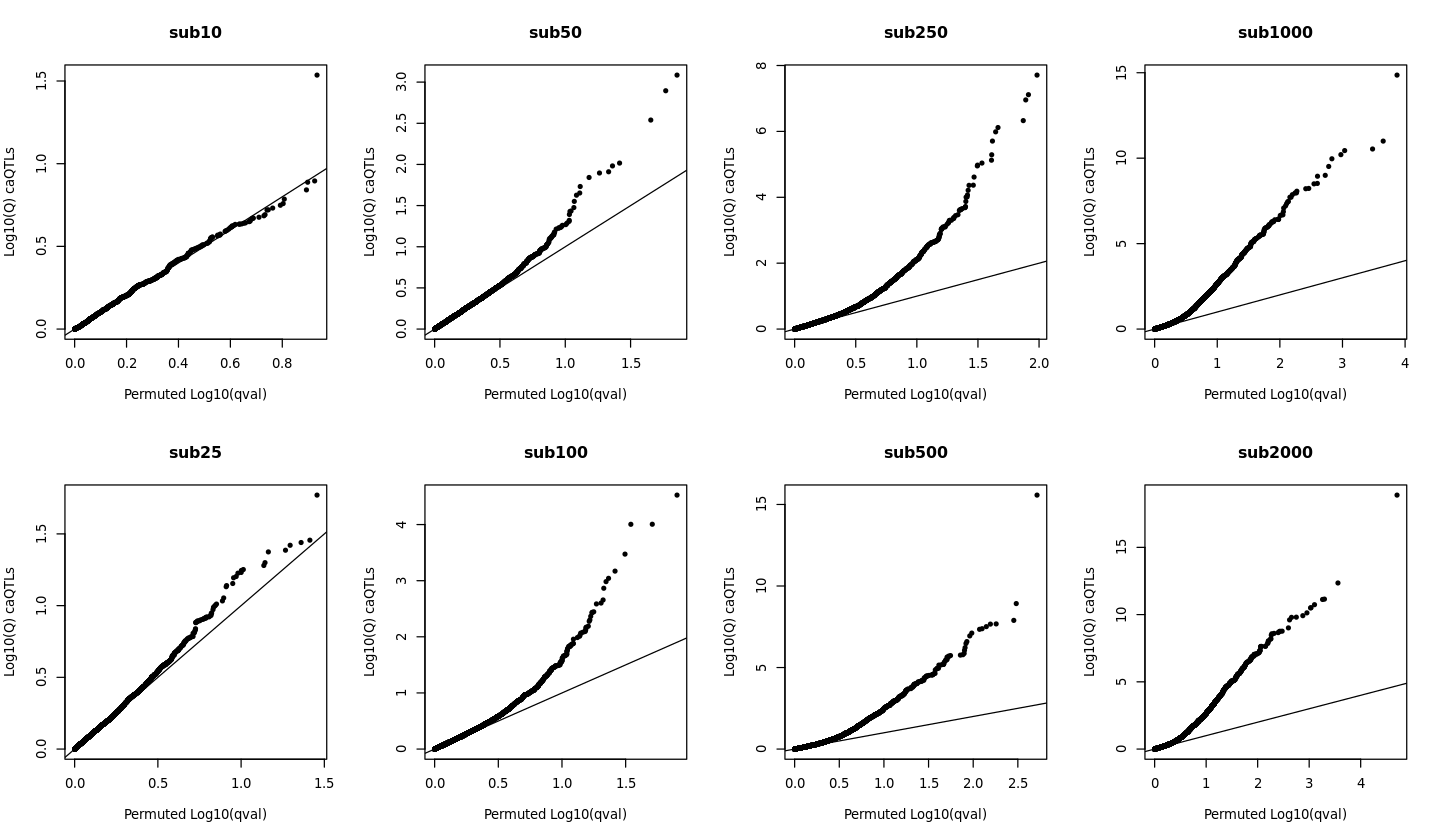

In [65]:
options(repr.plot.width=12, repr.plot.height=7)
par(mfcol=c(2,4))
for (c in celltypes[order(as.numeric(substring(celltypes,4)))]) {
results_lead       = read.table(paste0(c, "/Results_run1_lead.tsv"), header=T, stringsAsFactors = F)
random             = read.table(paste0(c, "/Results_run2_perm1_lead.tsv"), header=T, stringsAsFactors = F)
 
p1 = sort(-results_lead[,10])
p2 = sort(-random[,10])
plot(p2, p1, pch=20, cex=1, xlab="Permuted Log10(qval)", ylab="Log10(Q) caQTLs", main=c)
abline(0,1)
    results_lead$cell =c
   #res= rbind(res,results_lead )
    
   # qqplotf(results_lead$P_VAl, c)
    
    }

In [66]:
res_tot = data.frame()
for (c in celltypes) {
results_lead       = read.table(paste0(c, "/Results_run1_lead.tsv"), header=T, stringsAsFactors = F)
    results_lead$cell = c
res_tot = rbind(res_tot, results_lead)
    }

In [76]:
mono = read.table(paste0('/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/fine/cMono', "/Results_run3_lead.tsv"), header=T, stringsAsFactors = F)
mono$exclude = mono$Sequencing_mapping_error_rate>0.1 | mono$Ref_allele_bias<0.2 | mono$Ref_allele_bias>0.8
mono $cell ="cMono"
res_tot = rbind(res_tot, mono)

In [80]:
library(tidyr)

In [110]:
res_tot$signif = res_tot$flag_fdr10 & res_tot$exclude==FALSE


In [111]:
wide = spread(data = res_tot[,c('Feature', 'cell', 'signif')], key=cell, value =signif )

In [112]:
head(wide)

,Feature,cMono,sub10,sub100,sub1000,sub2000,sub25,sub250,sub50,sub500
,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,chr1:100151120-100151684,FALSE,NA,NA,FALSE,FALSE,NA,NA,NA,FALSE
2,chr1:100165577-100166150,FALSE,NA,NA,FALSE,FALSE,NA,FALSE,NA,FALSE
3,chr1:100169885-100170157,FALSE,NA,NA,FALSE,FALSE,NA,NA,NA,NA
4,chr1:100173116-100173470,FALSE,NA,NA,FALSE,FALSE,NA,FALSE,NA,FALSE
5,chr1:100191587-100191938,FALSE,NA,NA,NA,FALSE,NA,NA,NA,NA
6,chr1:100193227-100193607,FALSE,NA,NA,NA,FALSE,NA,NA,NA,NA


In [113]:
sigM = subset(wide, cMono==TRUE)

In [114]:
nrow(sigM)

[1] 2941

In [115]:
pct = setNames(rep(NA,8),celltypes)
for (c in celltypes){
    
    c1 =subset(wide, wide[,c]==TRUE)
    pct[c]   <- sum(c1[,"cMono"], na.rm=T)/sum( c1[,c])
}

In [116]:
pct

sub10    sub100   sub1000   sub2000     sub25    sub250     sub50    sub500 
0.0000000 0.8152174 0.8159117 0.8366843 1.0000000 0.8550000 0.6250000 0.8245098

In [95]:
#res_tot$signif5 = res_tot$flag_fdr05 & res_tot$exclude==FALSE


In [101]:
#wide5 = spread(data = res_tot[,c('Feature', 'cell', 'signif5')], key=cell, value =signif5 )

In [102]:
# pct = setNames(rep(NA,8),celltypes)
# for (c in celltypes){
    
#     c1 =subset(wide5, wide5[,c]==TRUE)
#     pct[c]   <- sum(c1[,"cMono"], na.rm=T)/sum( c1[,c])
# }

In [103]:
pct

sub10    sub100   sub1000   sub2000     sub25    sub250     sub50    sub500 
0.0000000 0.7704918 0.7930720 0.8049052 0.5000000 0.8735632 0.7142857 0.8396226

In [117]:
df$no_cells = as.numeric(substring(celltypes,4))
df$recall = pct

In [119]:
df = df[order(df$no_cells),]